<a href="https://colab.research.google.com/github/AndromathArcanitus/Sciences/blob/master/testPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages Loading

In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle

## Data Loading

In [ ]:
#df = pd.read_csv('./data/primary_clinical_radiomic_features/complete_clinical_radiomic_features_20220510.csv')
df = pd.read_csv('./complete_clinical_radiomic_features_20220510.csv')

## Data Exploration

In [ ]:
df.shape

(175, 655)

In [ ]:
df.head()

,MRN,Primary_Recurrence,hpv_total,Clinical N Stage,Clinical T Stage,Concurrent Chemo Regimen_cat_4,Treatment Laterality,pack_year_strat,tx_duration_strat,Disease Site_cat_0,...,original_glszm_SmallAreaHighGrayLevelEmphasis-ct_diff,original_glszm_SmallAreaLowGrayLevelEmphasis-ct_diff,original_glszm_ZoneEntropy-ct_diff,original_glszm_ZonePercentage-ct_diff,original_glszm_ZoneVariance-ct_diff,original_ngtdm_Busyness-ct_diff,original_ngtdm_Coarseness-ct_diff,original_ngtdm_Complexity-ct_diff,original_ngtdm_Contrast-ct_diff,original_ngtdm_Strength-ct_diff
0,94608596,0.0,1,1,3,0,2,2,0,0,...,0.263881,-0.821938,0.009144,-0.127575,0.164118,-0.397751,0.109260,0.221093,-1.721071,0.585230
1,94685469,0.0,1,2,4,0,2,2,1,0,...,0.185490,-1.211781,0.015916,-0.133305,0.191036,0.070698,-0.335800,0.121717,-4.346959,-0.011635
2,93724579,0.0,1,0,3,0,2,2,0,0,...,0.548389,-1.841186,0.042348,-0.494975,0.349844,-0.694662,0.123868,0.336382,-10.307440,0.603565
3,94659105,0.0,1,1,2,0,2,0,0,0,...,0.447048,-0.907776,0.064297,-0.135727,-0.275819,-0.488918,0.131763,0.447150,-0.953653,0.384193
4,93391511,0.0,0,0,3,0,2,1,0,1,...,-0.103750,0.381798,-0.003017,0.474527,-2.022937,0.252527,-0.174755,0.366038,0.708984,-1.060524


In [ ]:
df['Primary_Recurrence'] = df['Primary_Recurrence'].astype(int)

In [ ]:
df.dtypes.value_counts()

float64    643
int64       12
dtype: int64

#### Check for missing values

In [ ]:
print('Total missing values in the data set: ', sum(df.isnull().sum()))
print('No further actions for missing data needed.')

Total missing values in the data set:  0
No further actions for missing data needed.


#### Plot labels to see if the data set is unbalanced

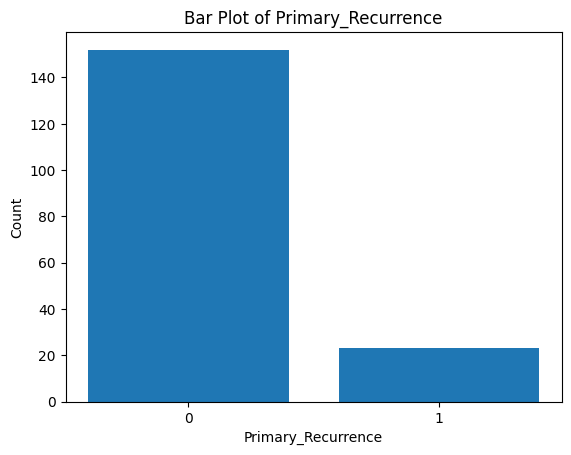

In [ ]:
Primary_Recurrence_count = df['Primary_Recurrence'].value_counts()

plt.bar(Primary_Recurrence_count.index, Primary_Recurrence_count.values)
plt.xlabel('Primary_Recurrence')
plt.ylabel('Count')
plt.title('Bar Plot of Primary_Recurrence')
plt.xticks(list(map(int, Primary_Recurrence_count.index)))
plt.show()

## Data Transformation
#### Encode categorical variables

In [ ]:
category_var_as_int = ['hpv_total', 'Clinical N Stage', 'Clinical T Stage', 'Treatment Laterality', 'pack_year_strat', 'tx_duration_strat']

for column in category_var_as_int:
    df = pd.get_dummies(df, columns=[column], prefix=[column])

#### Scale numerical features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = df.select_dtypes(include = ['float64'])

scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(numerical_features)
df[numerical_features.columns] = normalized_features

#### Distinguish predictors and outcomes

In [ ]:
X = df.drop(columns = ['MRN', 'Primary_Recurrence'])
y = df['Primary_Recurrence']

## Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

random_state = np.random.randint(1000)
# Split the data in a 60-20-20 fashion
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state = random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = random_state)

## Feature Selection

In [ ]:
num_features_to_select = 30

#### 1. using RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Temporarily using the Logistic regression model
REF_LR_model = LogisticRegression(max_iter = 1000)

rfe_selector = RFE(estimator = REF_LR_model, n_features_to_select = num_features_to_select)

rfe_selector.fit(X, y)

selected_features1 = rfe_selector.support_

In [ ]:
print("Selected Features:")
selected_features1_index = X.columns[selected_features1 == True]
print(selected_features1_index)

Selected Features:
Index(['original_shape_Maximum2DDiameterRow-pet_postrt',
       'original_shape_MinorAxisLength-pet_postrt',
       'original_gldm_DependenceNonUniformity-pet_postrt',
       'original_glrlm_ShortRunEmphasis-pet_postrt',
       'original_glszm_GrayLevelNonUniformity-pet_postrt',
       'original_shape_MajorAxisLength-pet_prert',
       'original_shape_Maximum2DDiameterSlice-pet_prert',
       'original_firstorder_Kurtosis-pet_prert',
       'original_shape_Maximum2DDiameterColumn-ct_postrt',
       'original_shape_Maximum2DDiameterRow-ct_postrt',
       'original_shape_MinorAxisLength-ct_postrt',
       'original_firstorder_10Percentile-ct_postrt',
       'original_firstorder_Mean-ct_postrt',
       'original_gldm_LowGrayLevelEmphasis-ct_postrt',
       'original_gldm_SmallDependenceLowGrayLevelEmphasis-ct_postrt',
       'original_glrlm_ShortRunLowGrayLevelEmphasis-ct_postrt',
       'original_glszm_HighGrayLevelZoneEmphasis-ct_postrt',
       'original_glszm_LargeA

#### 2. using LASSO

In [ ]:
from sklearn.linear_model import Lasso

alphas = np.logspace(4, -4, 200)

# Use a loop to find a model that keeps the desired number of predictors
num_of_predictors = 0
i = 0

while num_of_predictors <= num_features_to_select:
    # create a Lasso model for feature selection
    lasso_selector = Lasso(alpha = alphas[i], max_iter = 10000)

    lasso_selector.fit(X, y)

    selected_features2 = lasso_selector.coef_ != 0

    num_of_predictors = sum(selected_features2)
    i += 1

print('i = ', i)

i =  161


In [ ]:
print("Selected Features:")
selected_features2_index = X.columns[selected_features2 == True]
print(selected_features2_index)

Selected Features:
Index(['Age at Diagnosis', 'original_shape_MinorAxisLength-pet_postrt',
       'original_firstorder_Minimum-pet_postrt',
       'original_gldm_DependenceNonUniformity-pet_postrt',
       'original_glszm_GrayLevelNonUniformity-pet_postrt',
       'original_shape_Maximum2DDiameterSlice-pet_prert',
       'original_shape_SurfaceArea-pet_prert',
       'original_firstorder_Kurtosis-pet_prert',
       'original_shape_Maximum2DDiameterRow-ct_postrt',
       'original_shape_MinorAxisLength-ct_postrt',
       'original_firstorder_10Percentile-ct_postrt',
       'original_firstorder_90Percentile-ct_postrt',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis-ct_postrt',
       'original_gldm_SmallDependenceLowGrayLevelEmphasis-ct_postrt',
       'original_glszm_HighGrayLevelZoneEmphasis-ct_postrt',
       'original_glszm_LargeAreaHighGrayLevelEmphasis-ct_postrt',
       'original_glszm_SizeZoneNonUniformityNormalized-ct_postrt',
       'original_shape_SurfaceArea-ct_pre

#### 3. using univariate LR + Pearson coefficient

In [ ]:
# Calculate Pearson correlation coefficient
correlation_coefficient = X.corrwith(y)

# Perform univariate logistic regression
logistic_regression_p_values = []
for feature_name in X.columns:
    X_feature = X[feature_name].values.reshape(-1, 1)

    # Fit logistic regression model
    lr_model = LogisticRegression()
    lr_model.fit(X_feature, y)

    # Get the p-value from logistic regression
    p_value = lr_model.coef_[0][0]
    logistic_regression_p_values.append(p_value)

# Combine the results into a DataFrame
selected_features3 = pd.DataFrame({
    'Pearson_Coefficient': correlation_coefficient,
    'Logistic_Regression_P_Value': logistic_regression_p_values
})

# Select features based on p-value and Pearson_Coefficient
selected_features3 = selected_features3[selected_features3['Logistic_Regression_P_Value'] <= 0.05]

# Use a loop to find a list of features of the desired length
# Starting from absolute correlation of 0.1
num_features_kept = 0
corr = 0.51
while num_features_kept < num_features_to_select:
    corr -= 0.01
    num_features_kept = (abs(selected_features3['Pearson_Coefficient']) >= corr).sum()

In [ ]:
selected_features3 = selected_features3[abs(selected_features3['Pearson_Coefficient']) >= corr]
# Print selected features
print("Selected Features:")
print(selected_features3.index)

Selected Features:
Index(['original_shape_Sphericity-pet_postrt',
       'original_shape_SurfaceVolumeRatio-pet_postrt',
       'original_firstorder_Minimum-pet_postrt',
       'original_shape_Sphericity-pet_prert',
       'original_shape_SurfaceVolumeRatio-pet_prert',
       'original_shape_Sphericity-ct_postrt',
       'original_shape_SurfaceVolumeRatio-ct_postrt',
       'original_firstorder_RobustMeanAbsoluteDeviation-ct_postrt',
       'original_glcm_Contrast-ct_postrt',
       'original_glcm_DifferenceVariance-ct_postrt',
       'original_gldm_LowGrayLevelEmphasis-ct_postrt',
       'original_gldm_SmallDependenceLowGrayLevelEmphasis-ct_postrt',
       'original_glrlm_LowGrayLevelRunEmphasis-ct_postrt',
       'original_glrlm_ShortRunLowGrayLevelEmphasis-ct_postrt',
       'original_glszm_LowGrayLevelZoneEmphasis-ct_postrt',
       'original_glszm_SmallAreaLowGrayLevelEmphasis-ct_postrt',
       'original_ngtdm_Coarseness-ct_postrt',
       'original_ngtdm_Contrast-ct_postrt',
   

## Combining the Results

#### Find the intersection

In [ ]:
features_to_consider = selected_features1_index.intersection(selected_features2_index.intersection(selected_features3.index))

In [ ]:
features_to_consider

Index(['original_gldm_SmallDependenceLowGrayLevelEmphasis-ct_postrt', 'hpv_total_1'], dtype='object')

## Model Building

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

In [ ]:
features_to_consider = [selected_features1_index, selected_features2_index, selected_features3.index]

In [ ]:
# Define a list to store the split data
split_data = []
random_state = np.random.randint(1000)

# Perform the splits for different random states
for i in range(len(features_to_consider)):
    X_new = X[features_to_consider[i]]

    # Split the data in a 60-20-20 fashion
    X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size = 0.4, random_state = random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = random_state)

    # Store the split data in a tuple or a dictionary with a label (e.g., 'train' and 'test')
    split = {
        'X_train': X_train,
        'y_train': y_train,
        'X_validation': X_val,
        'y_validation': y_val,
        'X_test': X_test,
        'y_test': y_test
    }

    # Append the split data to the list
    split_data.append(split)

In [ ]:
# Access the split data for each random state
for i, split in enumerate(split_data):
    print(f"Random State {i + 1}:")
    print("Train Set:")
    print(split['X_train'].shape)

Random State 1:
Train Set:
(105, 30)
Random State 2:
Train Set:
(105, 34)
Random State 3:
Train Set:
(105, 34)


#### Logistic Regression

In [ ]:
# Define a dictionary to store the scores
dict_scores = []

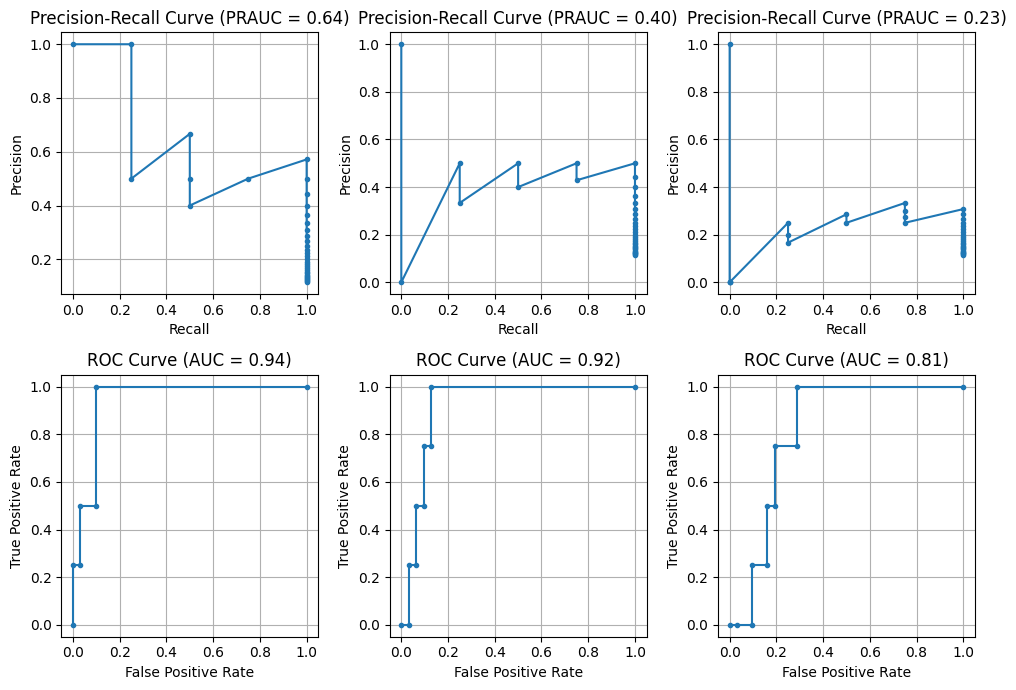

In [ ]:
# Use subplot to show the Precision-Recall curve and ROC-AUC in three cases
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

for i, split in enumerate(split_data):
    lr_model = LogisticRegression(max_iter = 1000)
    lr_model.fit(split['X_train'], split['y_train'])

    y_pred_prob = lr_model.predict_proba(split['X_test'])[:, 1]

    # Calculate and display the Precision-Recall curve and PRAUC
    precision, recall, _ = precision_recall_curve(split['y_test'], y_pred_prob)
    prauc = auc(recall, precision)

    axs[0, i].plot(recall, precision, marker='.')
    axs[0, i].set_xlabel('Recall')
    axs[0, i].set_ylabel('Precision')
    axs[0, i].set_title('Precision-Recall Curve (PRAUC = {:.2f})'.format(prauc))
    axs[0, i].grid(True)

    # Calculate and display the ROC curve and AUC
    fpr, tpr, _ = roc_curve(split['y_test'], y_pred_prob)
    roc_auc = roc_auc_score(split['y_test'], y_pred_prob)

    axs[1, i].plot(fpr, tpr, marker='.')
    axs[1, i].set_xlabel('False Positive Rate')
    axs[1, i].set_ylabel('True Positive Rate')
    axs[1, i].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
    axs[1, i].grid(True)

    dict_scores.append({"PRAUC" : prauc,"AUC" : roc_auc})

plt.tight_layout()
plt.show()

In [ ]:
# Show scores in the three cases
dict_scores1 = pd.DataFrame(dict_scores)
row_indices = ['From RFE', 'From LASSO', 'From Uni_LR + Corr']
dict_scores1.index = row_indices
dict_scores1

,PRAUC,AUC
From RFE,0.642262,0.943548
From LASSO,0.395238,0.919355
From Uni_LR + Corr,0.230426,0.814516


#### SVM

In [ ]:
dict_scores = []

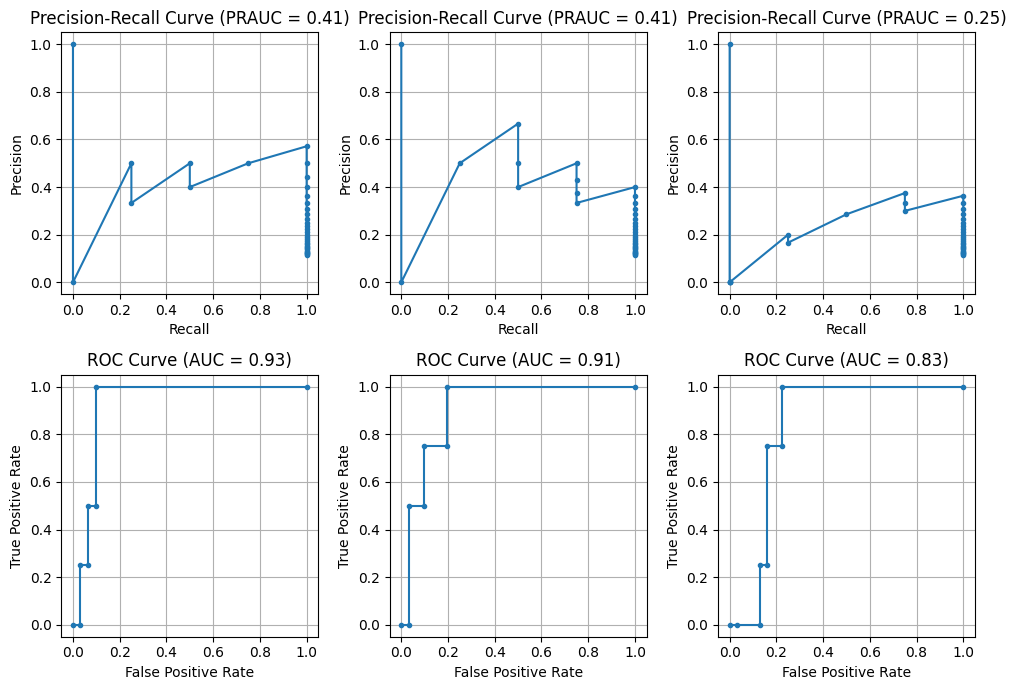

In [ ]:
from sklearn.svm import SVC
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

for i, split in enumerate(split_data):
    svm_model = SVC(probability=True)
    svm_model.fit(split['X_train'], split['y_train'])

    y_pred_prob = svm_model.predict_proba(split['X_test'])[:, 1]

    # Calculate and display the Precision-Recall curve and PRAUC
    precision, recall, _ = precision_recall_curve(split['y_test'], y_pred_prob)
    prauc = auc(recall, precision)

    axs[0, i].plot(recall, precision, marker='.')
    axs[0, i].set_xlabel('Recall')
    axs[0, i].set_ylabel('Precision')
    axs[0, i].set_title('Precision-Recall Curve (PRAUC = {:.2f})'.format(prauc))
    axs[0, i].grid(True)

    # Calculate and display the ROC curve and AUC
    fpr, tpr, _ = roc_curve(split['y_test'], y_pred_prob)
    roc_auc = roc_auc_score(split['y_test'], y_pred_prob)

    axs[1, i].plot(fpr, tpr, marker='.')
    axs[1, i].set_xlabel('False Positive Rate')
    axs[1, i].set_ylabel('True Positive Rate')
    axs[1, i].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
    axs[1, i].grid(True)

    dict_scores.append({"PRAUC" : prauc,"AUC" : roc_auc})

plt.tight_layout()
plt.show()

In [ ]:
# Show scores in the three cases
dict_scores2 = pd.DataFrame(dict_scores)
row_indices = ['From RFE', 'From LASSO', 'From Uni_LR + Corr']
dict_scores2.index = row_indices
dict_scores2

,PRAUC,AUC
From RFE,0.413095,0.927419
From LASSO,0.412500,0.911290
From Uni_LR + Corr,0.247091,0.830645


#### EBM

In [ ]:
!pip install interpret
from interpret.glassbox import ExplainableBoostingClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0

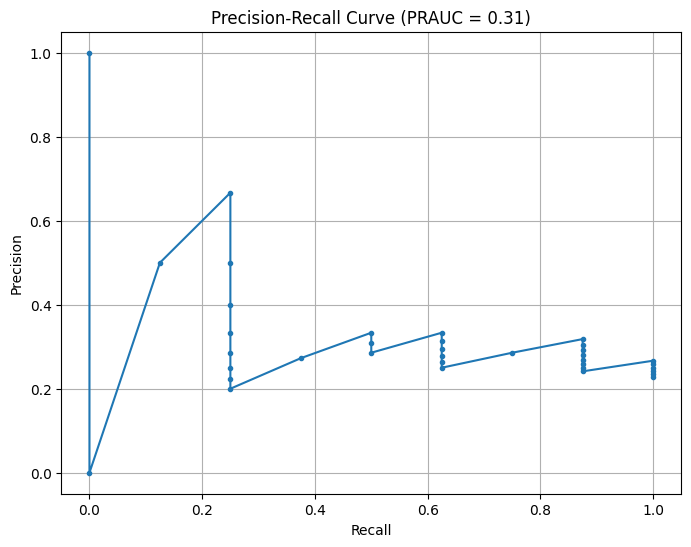

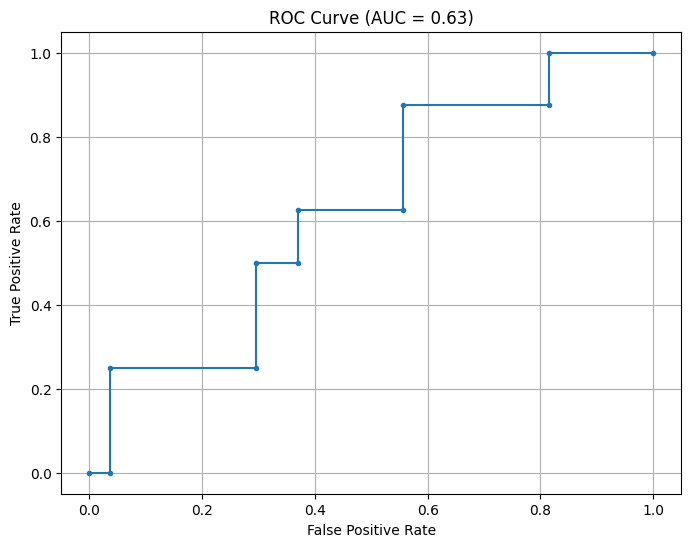

<Figure size 640x480 with 0 Axes>

In [ ]:
dict_scores = []


ebm_model = ExplainableBoostingClassifier()
ebm_model.fit(X_train, y_train)

y_pred = ebm_model.predict(X_test)

# Calculate and display the Precision-Recall curve and PRAUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
prauc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PRAUC = {:.2f})'.format(prauc))
plt.grid(True)
plt.show()

# Calculate and display the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.grid(True)
plt.show()

dict_scores.append({"PRAUC" : prauc,"AUC" : roc_auc})

plt.tight_layout()
plt.show()

In [ ]:
# Print the PRAUC and AUC scores
print('PRAUC:', prauc)
print('AUC:', roc_auc)

PRAUC: 0.31325990819525296
AUC: 0.6296296296296297
